<a href="https://colab.research.google.com/github/AsmatZahra/Unet-with-Monuseg-dataset/blob/master/UNet_with_MonuSeg_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Set-Up

In [258]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [259]:
%cd /content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3/

/content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3


In [260]:
!ls

model-tgs-monuseg.h5  model-tgs-salt.h5  MonuSeg  Untitled0.ipynb


2.Imports

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

3.Image Parameter-Setup

In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [0]:
ids = next(os.walk("MonuSeg/Training/TissueImages"))[2] # list of names all images in the given path
ids_groundTruth= next(os.walk("MonuSeg/Training/GroundTruth"))[2]
print("No. of images = ", len(ids))
print("No. of images_GroundTruth = ", len(ids_groundTruth))
print(ids)
print(ids_groundTruth)

In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [278]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_= id_[:-4]+"_bin_mask.png"
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5, 1.0, 'GroundTruth')

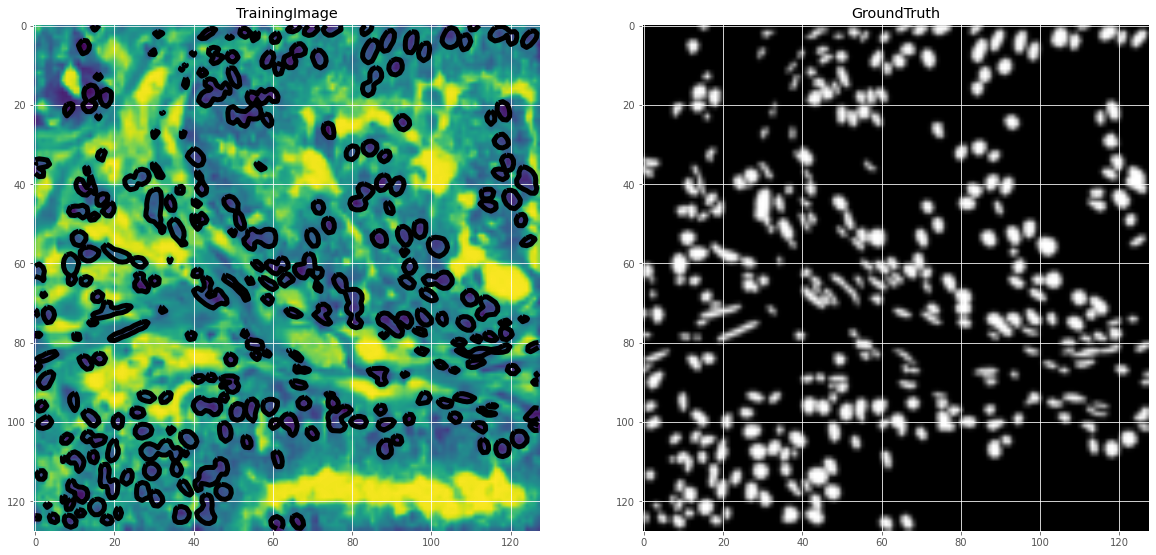

In [312]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X))
has_mask = y[ix].max() > 0 # nuclie indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating infected and non-infected areas
    ax1.contour(y[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TrainingImage')

ax2.imshow(y[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [316]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 128, 128, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_146 (BatchN (None, 128, 128, 32) 128         conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_146 (Activation)     (None, 128, 128, 32) 0           batch_normalization_146[0][0]    
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-monuseg.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [318]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 27 samples, validate on 3 samples
Epoch 1/100
27/27 [==============================] - 9s 316ms/step - loss: 0.6437 - acc: 0.1399 - val_loss: 0.5821 - val_acc: 0.1524

Epoch 00001: val_loss improved from inf to 0.58210, saving model to model-tgs-monuseg.h5
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 0.5790 - acc: 0.1604 - val_loss: 0.5927 - val_acc: 0.1468

Epoch 00002: val_loss did not improve from 0.58210
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 0.5415 - acc: 0.1640 - val_loss: 0.6288 - val_acc: 0.1010

Epoch 00003: val_loss did not improve from 0.58210
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 0.5203 - acc: 0.1648 - val_loss: 0.5947 - val_acc: 0.1406

Epoch 00004: val_loss did not improve from 0.58210
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 0.5008 - acc: 0.1674 - val_loss: 0.5790 - val_acc: 0.1544

Epoch 00005: val_loss improved from 0.58210 to 0.5790

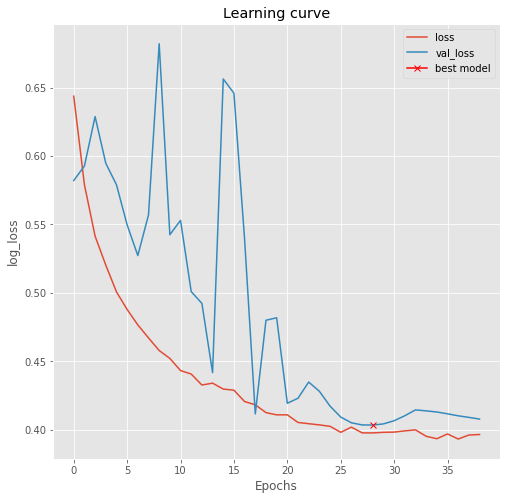

In [319]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-tgs-monuseg.h5')

In [321]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

3/3 [==============================] - 0s 5ms/step


[0.4035399258136749, 0.1606038361787796]

working on test set

In [322]:
ids_test= next (os.walk("MonuSeg/Test/TissueImages"))[2]
print ("No. of images= ", len (ids_test))

No. of images=  14


In [323]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_= id_[:-4]+"_bin_mask.png"
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
x_test= X
y_test= y

In [376]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(x_test, verbose=1)

30/30 [==============================] - 0s 2ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

4. Visualising Training, Validation and Testing Results

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='Accent')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Infected Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Infected Predicted binary');

index in print is: 8


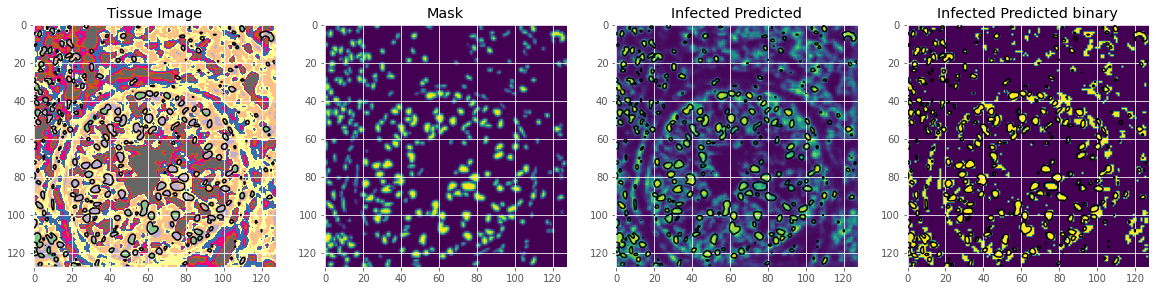

In [335]:
# Check if training data looks all right
ix = random.randint(0, len(X_train-3))
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=ix)
print("index in print is:", ix)

index in print is: 0


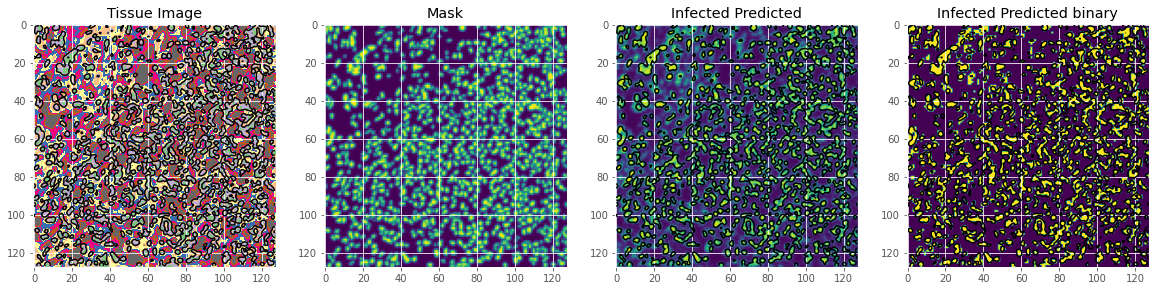

In [336]:
# Check if valid data looks all right
#ix = random.randint(0, len(X_valid-1))
ix=0
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=ix)
print("index in print is:", ix)

index in print is: 29


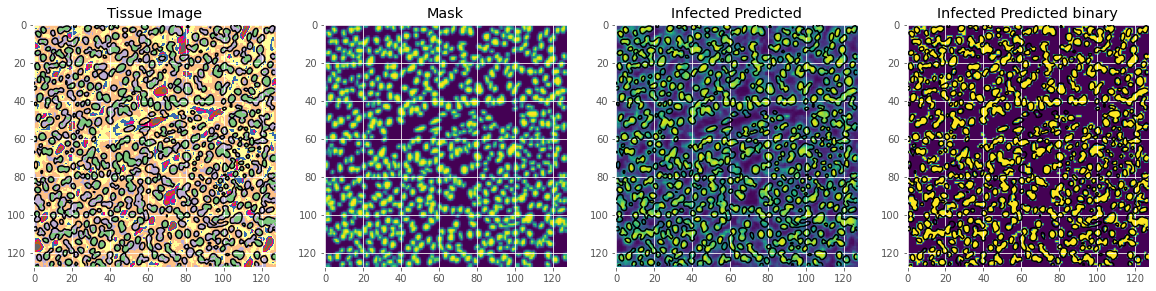

In [338]:
# Check if test data looks all right
ix = random.randint(0, len(x_test))
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=ix)
print("index in print is:", ix)

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [341]:
print("IOU: " , iou_coef(y_test, preds_test))
print("Dice: " , dice_coef(y_test, preds_test))

IOU:  Tensor("Mean_20:0", shape=(), dtype=float32)
Dice:  Tensor("Mean_21:0", shape=(), dtype=float32)


In [0]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, preds_test, target_names=target_names))

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,preds_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,preds_test, normalize='True')

In [0]:
preds_test=preds_test*100
print(preds_test)

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(preds_test, 50)



loading a model

In [382]:
!ls

model-tgs-monuseg.h5  model-tgs-salt.h5  MonuSeg  Untitled0.ipynb


In [0]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
# load model
model = load_model('model-tgs-monuseg.h5')
# summarize model.
model.summary()